In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline


In [2]:
# Define the file path and name
file_path = '/Users/shchan/Documents/Programming/Postgrad_Computer_science/Modules/CSCK503 Machine Learning in Practice June 2024/Week 8/Assignment/end of module assignment/data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'MajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

In [3]:
df.drop(columns=['MotorwayNumber', 'TLRN'], inplace = True)

In [4]:
import numpy as np

# Filter to CO2
df = df[df['Pollutant'] == 'CO2']

# # Step 1: Handling Missing values
# missing_values = df.isnull().sum()
# print("Missing values in each column:\n", missing_values)

# # Step 2: Removing Duplicates
# df = df.drop_duplicates()

# # Drop rows with NaN in 'CO2 emission'
# df = df.dropna(subset=['CO2 emission'])
# # Print the number of rows after dropping
# print(f"Number of rows after dropping NaN in 'CO2 emission': {df.shape[0]}")



# # Step 3: Outlier Detection and Treatment using IQR method
# numeric_df = df.select_dtypes(include=[np.number])


# Q1 = numeric_df.quantile(0.25, numeric_only=True)
# Q3 = numeric_df.quantile(0.75, numeric_only=True)
# IQR = Q3 - Q1

# # Aligning DataFrame and IQR series for proper comparison
# df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
# Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
# Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

# df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

# 

# 

# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

# Step 3: Outlier Detection and Treatment using IQR method

numeric_df = df.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25, numeric_only=True)
Q3 = numeric_df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

Missing values in each column:
 Unnamed: 0              0
GridId                  0
Toid                    0
GRID_ExactCut_ID        0
Location_ExactCut       0
BoroughName_ExactCut    0
Lts                     0
Length (m)              0
Emissions               0
Year                    0
Pollutant               0
Emissions Unit          0
VehicleType             0
Emission Value          0
RowID                   0
Speed (kph)             0
AADT                    0
VKM                     0
dtype: int64


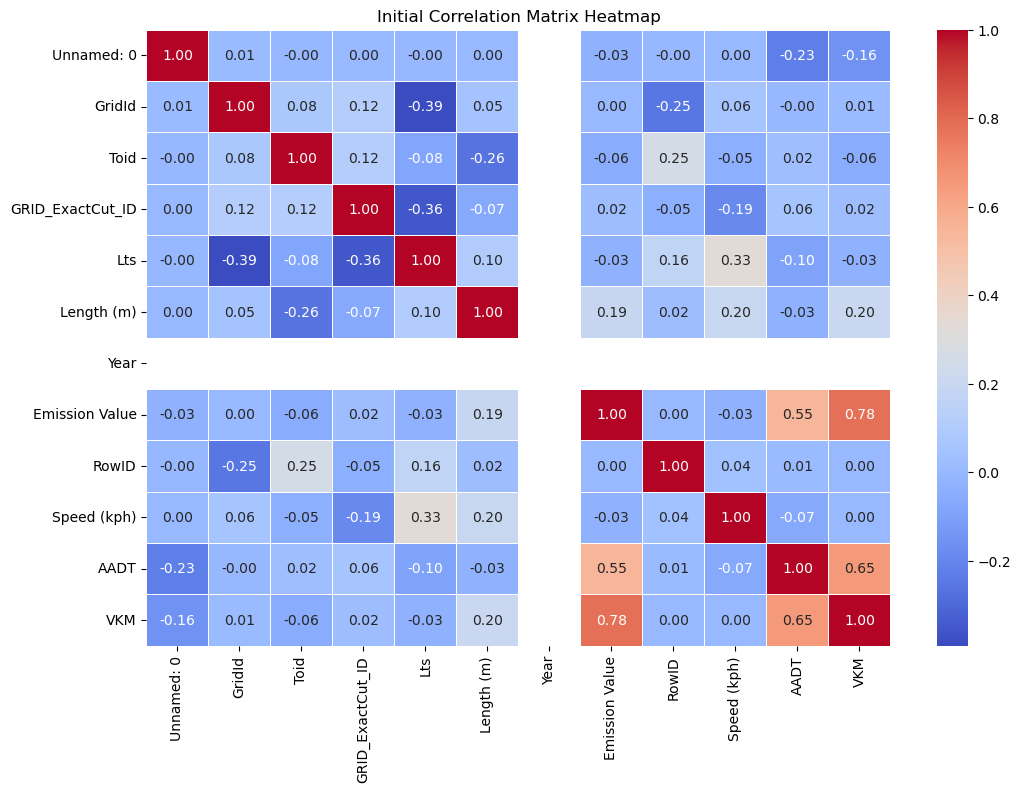

In [5]:
# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Initial heatmap of the correlation matrix
initial_correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

# # Initial heatmap of the correlation matrix
# initial_correlation_matrix = df.corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Initial Correlation Matrix Heatmap')
# plt.show()

In [6]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Emissions Unit', 'VehicleType', 'Pollutant']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['Emission Value'].abs().sort_values(ascending=False)
print(target_corr)

Emission Value          1.000000
VKM                     0.778763
AADT                    0.546873
Length (m)              0.193900
VehicleType             0.075468
Toid                    0.055868
Unnamed: 0              0.033606
Speed (kph)             0.032406
Lts                     0.031983
GRID_ExactCut_ID        0.018073
BoroughName_ExactCut    0.017632
Location_ExactCut       0.004152
RowID                   0.002650
GridId                  0.002186
Emissions                    NaN
Year                         NaN
Pollutant                    NaN
Emissions Unit               NaN
Name: Emission Value, dtype: float64


['Emission Value', 'VKM', 'AADT', 'Length (m)', 'VehicleType', 'Toid']


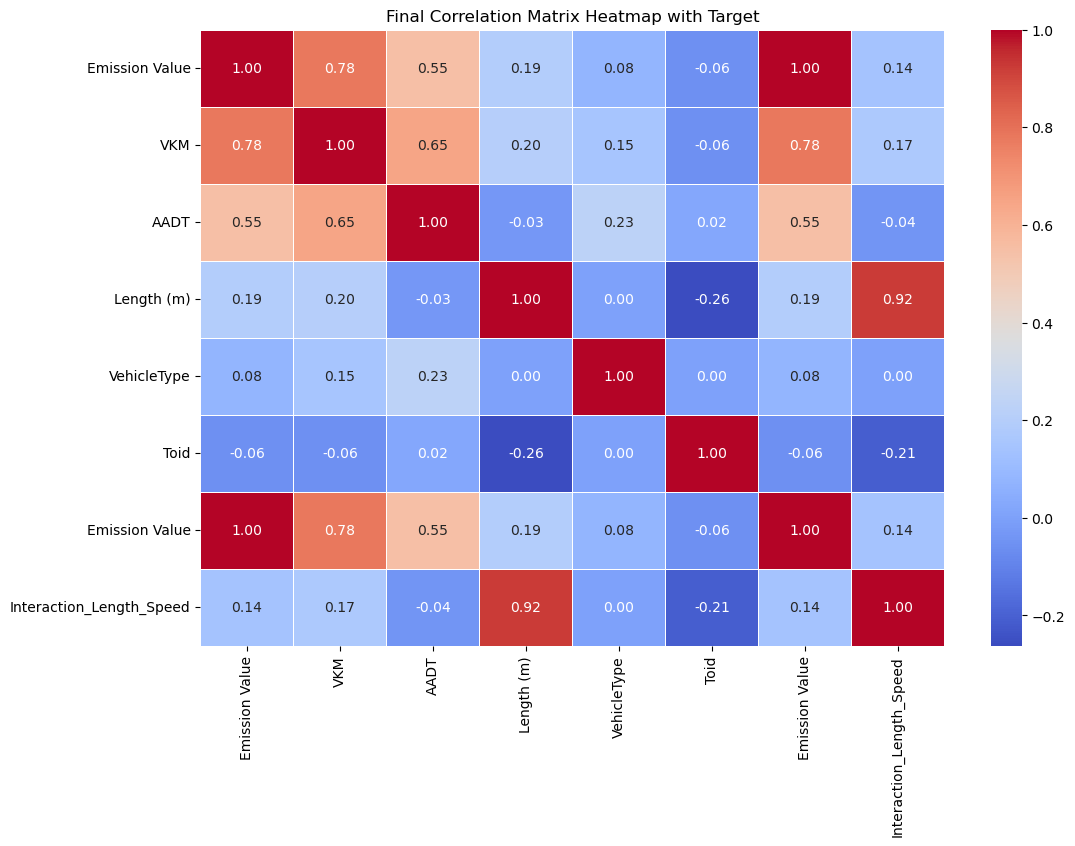

In [7]:
# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()
print(selected_features)
# # Add the target variable back to the selected features
selected_features.append('Emission Value')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
# df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# # Redefine features and preprocess again
# selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']
selected_features = selected_features + ['Interaction_Length_Speed']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

In [8]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['Emission Value'])
y = df['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

        VKM      AADT  Length (m)  VehicleType      Toid  \
0 -0.023502  0.095732   -0.327321     0.434524 -6.243198   
1 -0.246166 -0.353113   -0.578696     0.434524 -6.144199   
2  1.043801  0.095732    2.431609     0.434524 -6.298176   
3 -0.246166 -0.353113   -0.583481     0.434524 -6.298100   
4  0.915810  0.242550    1.360420     0.434524 -6.298087   

   Interaction_Length_Speed  
0                 -0.117514  
1                 -0.444328  
2                  2.061928  
3                 -0.455785  
4                  0.587842  


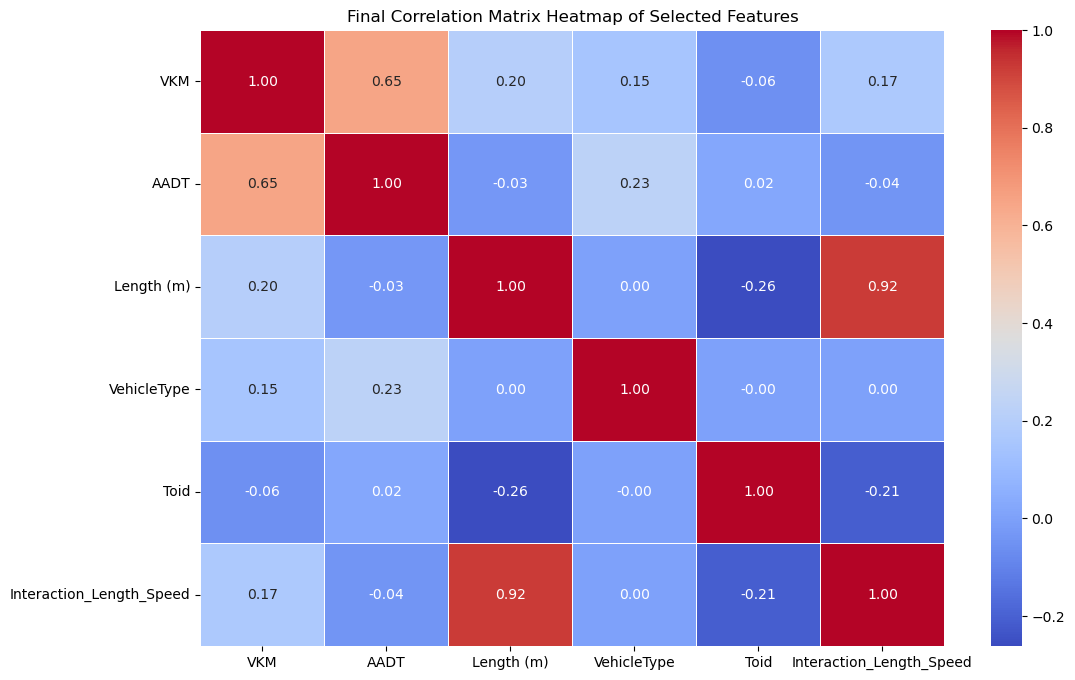

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [10]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)

{'X_train_shape': (269529, 6), 'X_test_shape': (67383, 6), 'y_train_shape': (269529,), 'y_test_shape': (67383,), 'features': ['Emission Value', 'VKM', 'AADT', 'Length (m)', 'VehicleType', 'Toid', 'Emission Value'], 'target': 'Emission Value'}


In [17]:
# # Train and evaluate Linear Regression
# linear_reg = LinearRegression()
# linear_reg.fit(X_train, y_train)
# y_pred_lr = linear_reg.predict(X_test)

In [17]:
# # Define the neural network model
# nn_model = Sequential()
# nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
# nn_model.add(Dropout(0.2))
# nn_model.add(Dense(32, activation='relu'))
# nn_model.add(Dense(1, activation='linear'))

# # Compile the model
# nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# # Make predictions
# y_pred_nn = nn_model.predict(X_test).flatten()

/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 5.3325 - val_loss: 2.8088
Epoch 2/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 6s 859us/step - loss: 3.4373 - val_loss: 2.5250
Epoch 3/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 6s 952us/step - loss: 2.2889 - val_loss: 1.6418
Epoch 4/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 5s 799us/step - loss: 1.9843 - val_loss: 1.5021
Epoch 5/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 6s 860us/step - loss: 1.6614 - val_loss: 1.4211
Epoch 6/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.6287 - val_loss: 1.2185
Epoch 7/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.3165 - val_loss: 1.1808
Epoch 8/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.3053 - val_loss: 1.2528
Epoch 9/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1.5929 - val_loss: 1.2740
Epoch 10/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.1729 - val_loss: 1.1180
Epoch 11/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0998 - val_loss: 1.3479
Epoch 12/50
6739/6739

In [11]:
# Define and test a few hyperparameter combinations
rf1 = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

rf2 = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

Random Forest Metrics RF1 (MAE, MSE, R^2): (0.3298620106879545, 1.4391687435291176, 0.9202351900300655)
Random Forest Metrics RF2 (MAE, MSE, R^2): (0.1570507218448625, 0.6635896552969519, 0.9632210586904643)


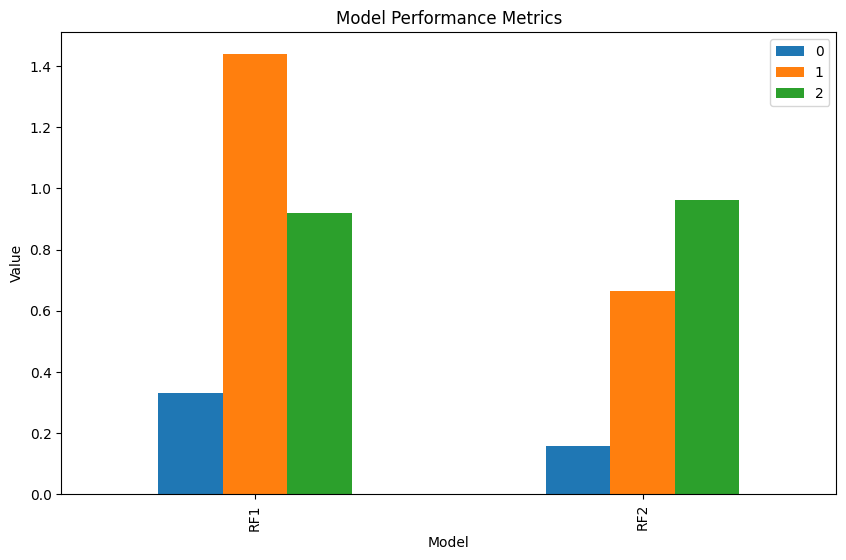

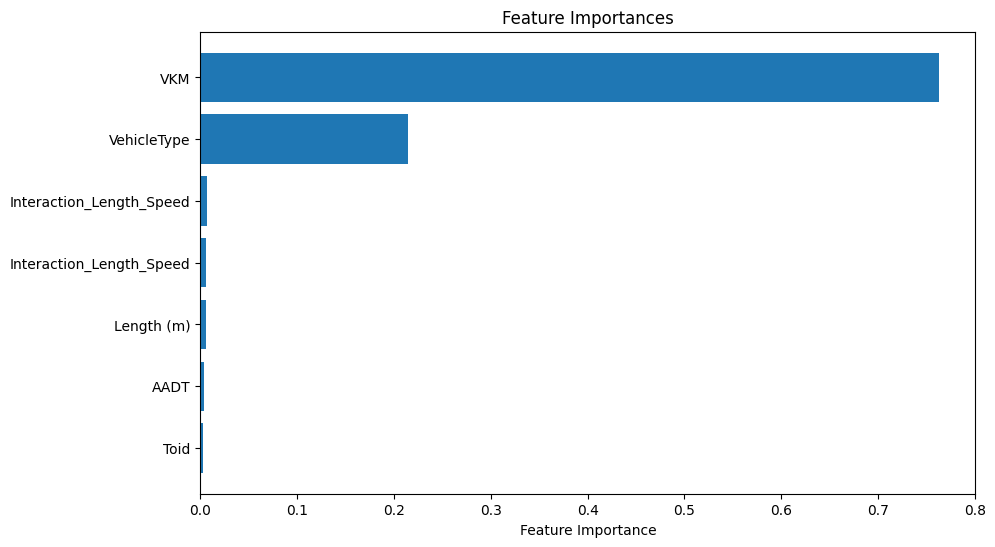

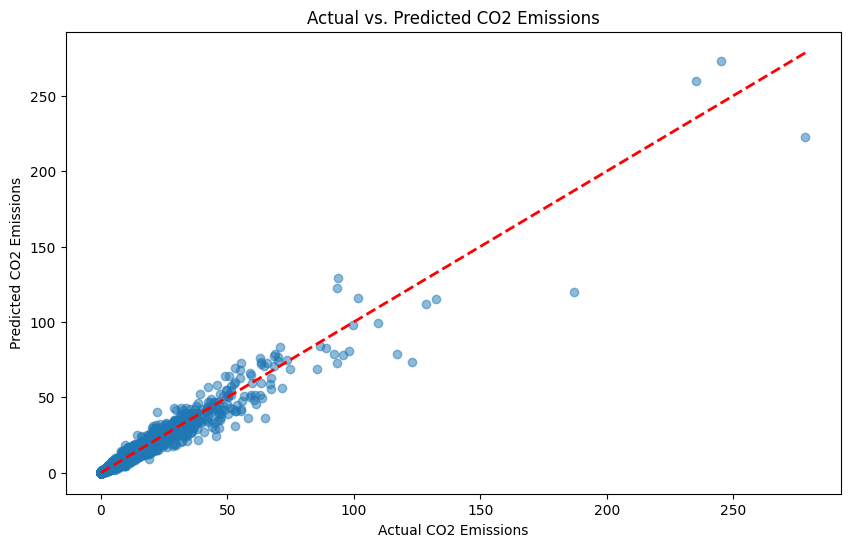

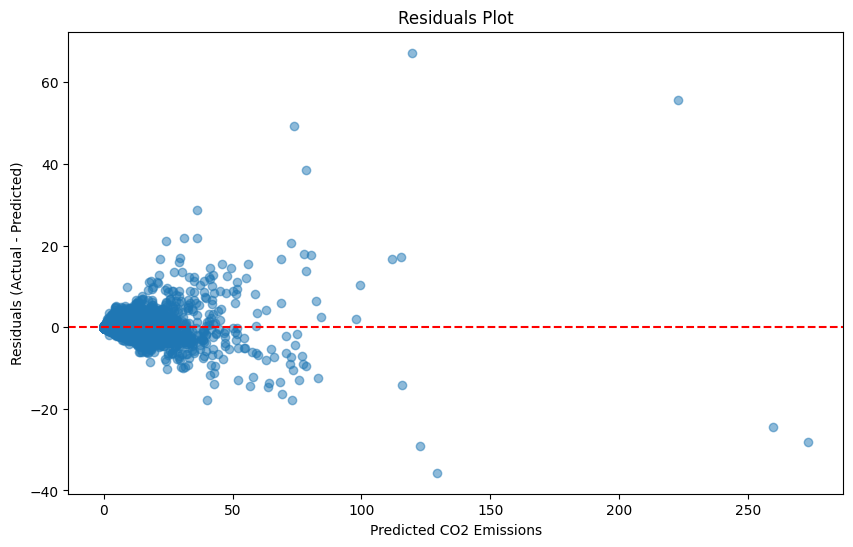

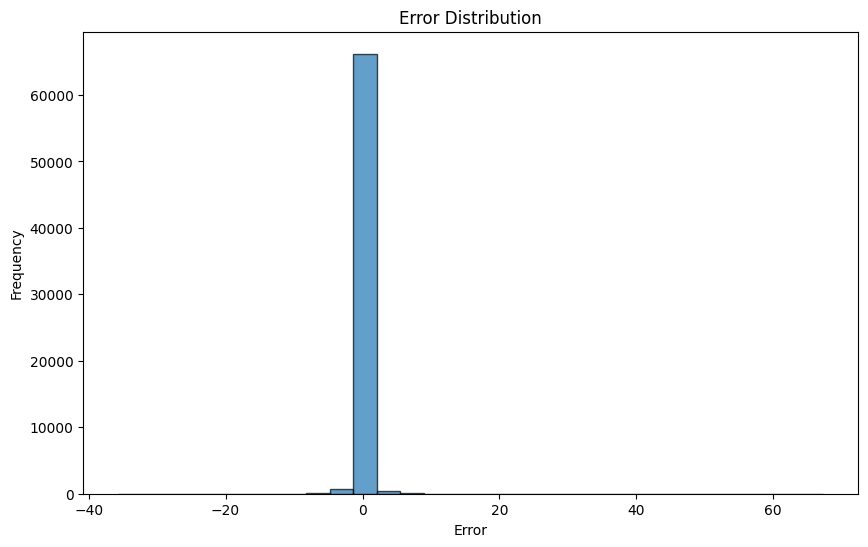

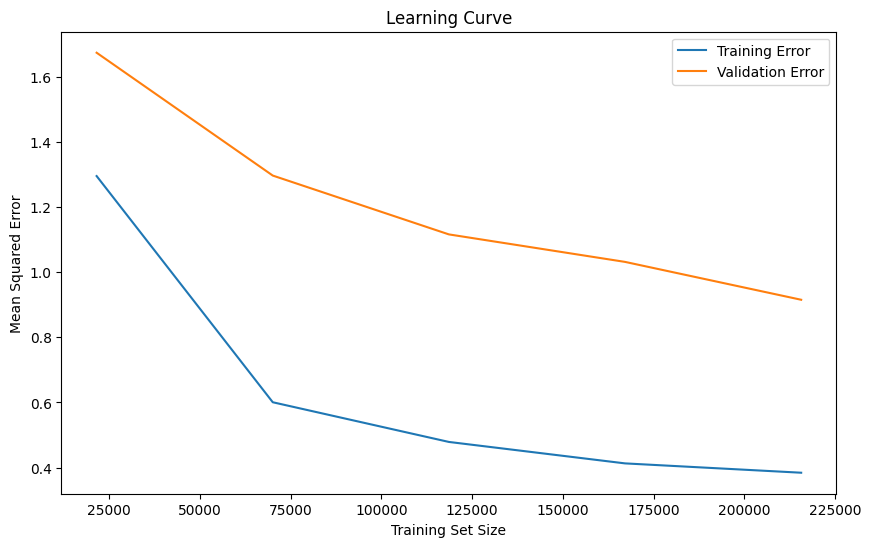

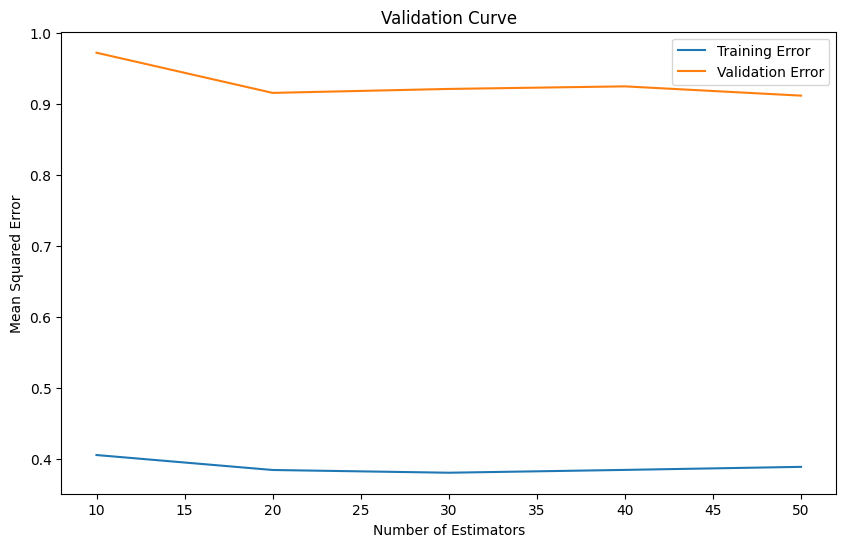

In [22]:

# Evaluate Models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# linear_metrics = evaluate_model(y_test, y_pred_lr)
rf1_metrics = evaluate_model(y_test, y_pred_rf1)
rf2_metrics = evaluate_model(y_test, y_pred_rf2)

# nn_metrics = evaluate_model(y_test, y_pred_nn)

# print("Linear Regression Metrics (MAE, MSE, R^2):", linear_metrics)
print("Random Forest Metrics RF1 (MAE, MSE, R^2):", rf1_metrics)
print("Random Forest Metrics RF2 (MAE, MSE, R^2):", rf2_metrics)
# print("Neural Network Metrics (MAE, MSE, R^2):", nn_metrics)

# Example bar chart for error metrics
metrics = {
    'RF1': rf1_metrics,
    'RF2': rf2_metrics
}

df_metrics = pd.DataFrame(metrics).T

df_metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.xlabel('Model')
plt.show()

# Feature importances
importances = rf2.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Feature Importance')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf2, alpha=0.5)
plt.title('Actual vs. Predicted CO2 Emissions')
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf2, y_test - y_pred_rf2, alpha=0.5)
plt.title('Residuals Plot')
plt.xlabel('Predicted CO2 Emissions')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

errors = y_test - y_pred_rf2

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Average scores
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Error')
plt.plot(train_sizes, test_mean, label='Validation Error')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

from sklearn.model_selection import validation_curve

param_range = [10, 20, 30, 40, 50]
train_scores, test_scores = validation_curve(rf2, X_train, y_train, param_name='n_estimators', param_range=param_range, scoring='neg_mean_squared_error')

# Average scores
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Error')
plt.plot(param_range, test_mean, label='Validation Error')
plt.title('Validation Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [12]:
from skopt import BayesSearchCV

# Define the parameter space
param_space = {
    'n_estimators': (10, 100),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20)
}

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                             search_spaces=param_space,
                             n_iter=50,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             random_state=42)

# Fit Bayesian search
bayes_search.fit(X_train, y_train)

# Best parameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [6, 9, 44]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [19, 16, 58]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [4, 14, 81]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [5, 9, 27]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimize

Best Hyperparameters: OrderedDict([('max_depth', 20), ('min_samples_split', 2), ('n_estimators', 100)])


AttributeError: 'BayesSearchCV' object has no attribute 'space'

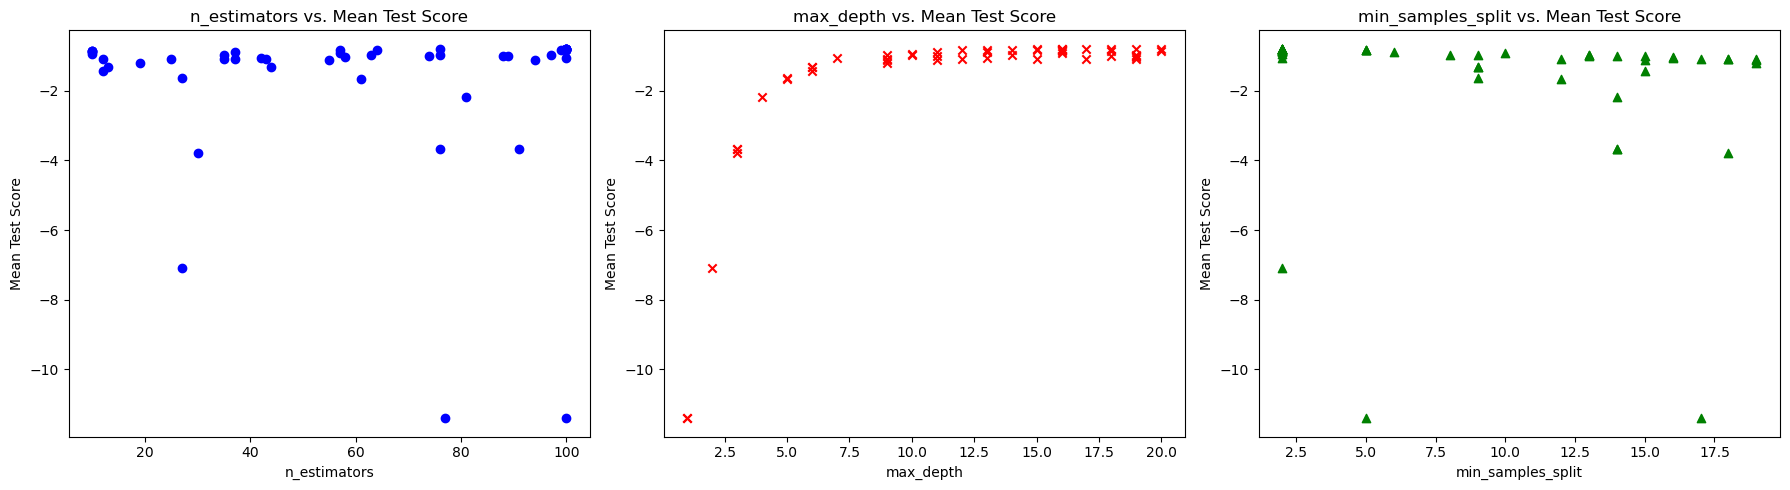

Best Hyperparameters: OrderedDict([('max_depth', 20), ('min_samples_split', 2), ('n_estimators', 100)])


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract results from BayesSearchCV
results = pd.DataFrame(bayes_search.cv_results_)

# Create subplots to visualize hyperparameter effects
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot n_estimators vs. mean_test_score
axs[0].scatter(results['param_n_estimators'], results['mean_test_score'], c='blue', marker='o')
axs[0].set_xlabel('n_estimators')
axs[0].set_ylabel('Mean Test Score')
axs[0].set_title('n_estimators vs. Mean Test Score')

# Plot max_depth vs. mean_test_score
axs[1].scatter(results['param_max_depth'], results['mean_test_score'], c='red', marker='x')
axs[1].set_xlabel('max_depth')
axs[1].set_ylabel('Mean Test Score')
axs[1].set_title('max_depth vs. Mean Test Score')

# Plot min_samples_split vs. mean_test_score
axs[2].scatter(results['param_min_samples_split'], results['mean_test_score'], c='green', marker='^')
axs[2].set_xlabel('min_samples_split')
axs[2].set_ylabel('Mean Test Score')
axs[2].set_title('min_samples_split vs. Mean Test Score')

plt.tight_layout()
plt.show()

# Best hyperparameters from Bayesian Optimization
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

In [16]:
# Extract the best hyperparameters
optimal_params = best_params

# Initialize the Random Forest model with optimal parameters
optimal_rf = RandomForestRegressor(
    n_estimators=optimal_params['n_estimators'],
    max_depth=optimal_params['max_depth'],
    min_samples_split=optimal_params['min_samples_split'],
    random_state=42
)

# Fit the model
optimal_rf.fit(X_train, y_train)

# Make predictions
y_pred_optimal = optimal_rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_optimal)
mse = mean_squared_error(y_test, y_pred_optimal)
r2 = r2_score(y_test, y_pred_optimal)

print("Performance with Optimal Hyperparameters:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Performance with Optimal Hyperparameters:
Mean Absolute Error (MAE): 0.09615430353533201
Mean Squared Error (MSE): 0.5638661624444575
R^2 Score: 0.9687481558378158


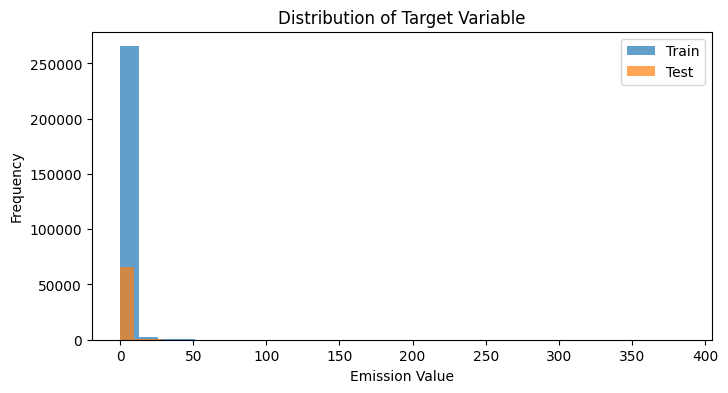

In [21]:
# # Plot the distribution of target values
# plt.figure(figsize=(8, 4))
# plt.hist(y_train, bins=30, alpha=0.7, label='Train')
# plt.hist(y_test, bins=30, alpha=0.7, label='Test')
# plt.title('Distribution of Target Variable')
# plt.xlabel('Emission Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# # # Plot predictions vs. actual values
# # plt.figure(figsize=(8, 6))
# # plt.scatter(y_test, y_pred_nn, alpha=0.5)
# # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
# # plt.title('Predictions vs. Actual Values')
# # plt.xlabel('Actual Values')
# # plt.ylabel('Predicted Values')
# # plt.show()

# # # Plot training and validation loss
# # plt.figure(figsize=(10, 6))
# # plt.plot(history.history['loss'], label='Training Loss')
# # plt.plot(history.history['val_loss'], label='Validation Loss')
# # plt.title('Training and Validation Loss')
# # plt.xlabel('Epochs')
# # plt.ylabel('Loss')
# # plt.legend()
# # plt.show()

In [26]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# selected_features = [feature for feature in selected_features if feature != 'CO2 emission']

# # Calculate VIF for each feature
# X_with_const = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])
# print(f"X_with_const shape: {X_with_const.shape}")

# vif_data = pd.DataFrame()
# vif_data["Feature"] = ['Intercept'] + selected_features
# print(f"Feature names: {vif_data['Feature']}")
# vif_data["VIF"] = [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]

# print(vif_data)

X_with_const shape: (336912, 8)
Feature names: 0                   Intercept
1                         VKM
2                        AADT
3                  Length (m)
4                 VehicleType
5                        Toid
6    Interaction_Length_Speed
7        Interaction_AADT_VKM
Name: Feature, dtype: object
                    Feature       VIF
0                 Intercept  1.000000
1                       VKM  3.577404
2                      AADT  1.901681
3                Length (m)  7.369734
4               VehicleType  1.064587
5                      Toid  1.080977
6  Interaction_Length_Speed  6.925441
7      Interaction_AADT_VKM  2.295945
